# Speech-to-Text CTC web inference using Gradio

Encoder model + CTC loss web inference using Gradio

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/stt-ctc-gradio](https://github.com/huseinzol05/malaya-speech/tree/master/example/stt-ctc-gradio).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

### List available CTC model

In [2]:
malaya_speech.stt.available_ctc()

,Size (MB),Quantized Size (MB),WER,CER,WER-LM,CER-LM,Language
hubert-conformer-tiny,36.6,10.3,0.335968,0.0882573,0.199227,0.0635223,[malay]
hubert-conformer,115,31.1,0.238714,0.0608998,0.141479,0.0450751,[malay]
hubert-conformer-large,392,100,0.220314,0.054927,0.128006,0.0385329,[malay]
hubert-conformer-large-3mixed,392,100,0.241126,0.0787939,0.132761,0.057482,"[malay, singlish, mandarin]"
best-rq-conformer-tiny,36.6,10.3,0.319291,0.078988,0.179582,0.055521,[malay]
best-rq-conformer,115,31.1,0.253678,0.0658045,0.154206,0.0482278,[malay]
best-rq-conformer-large,392,100,0.234651,0.0601605,0.130082,0.044521,[malay]


Lower is better. Mixed models tested on different dataset.

### Load CTC model

```python
def deep_ctc(
    model: str = 'hubert-conformer', quantized: bool = False, **kwargs
):
    """
    Load Encoder-CTC ASR model.

    Parameters
    ----------
    model : str, optional (default='hubert-conformer')
        Model architecture supported. Allowed values:

        * ``'hubert-conformer-tiny'`` - Finetuned HuBERT Conformer TINY.
        * ``'hubert-conformer'`` - Finetuned HuBERT Conformer.
        * ``'hubert-conformer-large'`` - Finetuned HuBERT Conformer LARGE.
        * ``'hubert-conformer-large-3mixed'`` - Finetuned HuBERT Conformer LARGE for (Malay + Singlish + Mandarin) languages.
        * ``'best-rq-conformer-tiny'`` - Finetuned BEST-RQ Conformer TINY.
        * ``'best-rq-conformer'`` - Finetuned BEST-RQ Conformer.
        * ``'best-rq-conformer-large'`` - Finetuned BEST-RQ Conformer LARGE.


    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model.
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.model.tf.Wav2Vec2_CTC class
    """
```

In [3]:
model = malaya_speech.stt.deep_ctc(model = 'hubert-conformer')

### web inference using Gradio

```python
def gradio(self, record_mode: bool = True,
           lm_func: Callable = None,
           **kwargs):
    """
    Transcribe an input using beam decoder on Gradio interface.

    Parameters
    ----------
    record_mode: bool, optional (default=True)
        if True, Gradio will use record mode, else, file upload mode.
    lm_func: Callable, optional (default=None)
        if not None, will pass a logits with shape [T, D].

    **kwargs: keyword arguments for beam decoder and `iface.launch`.
    """
```

#### record mode

In [6]:
model.gradio(record_mode = True)

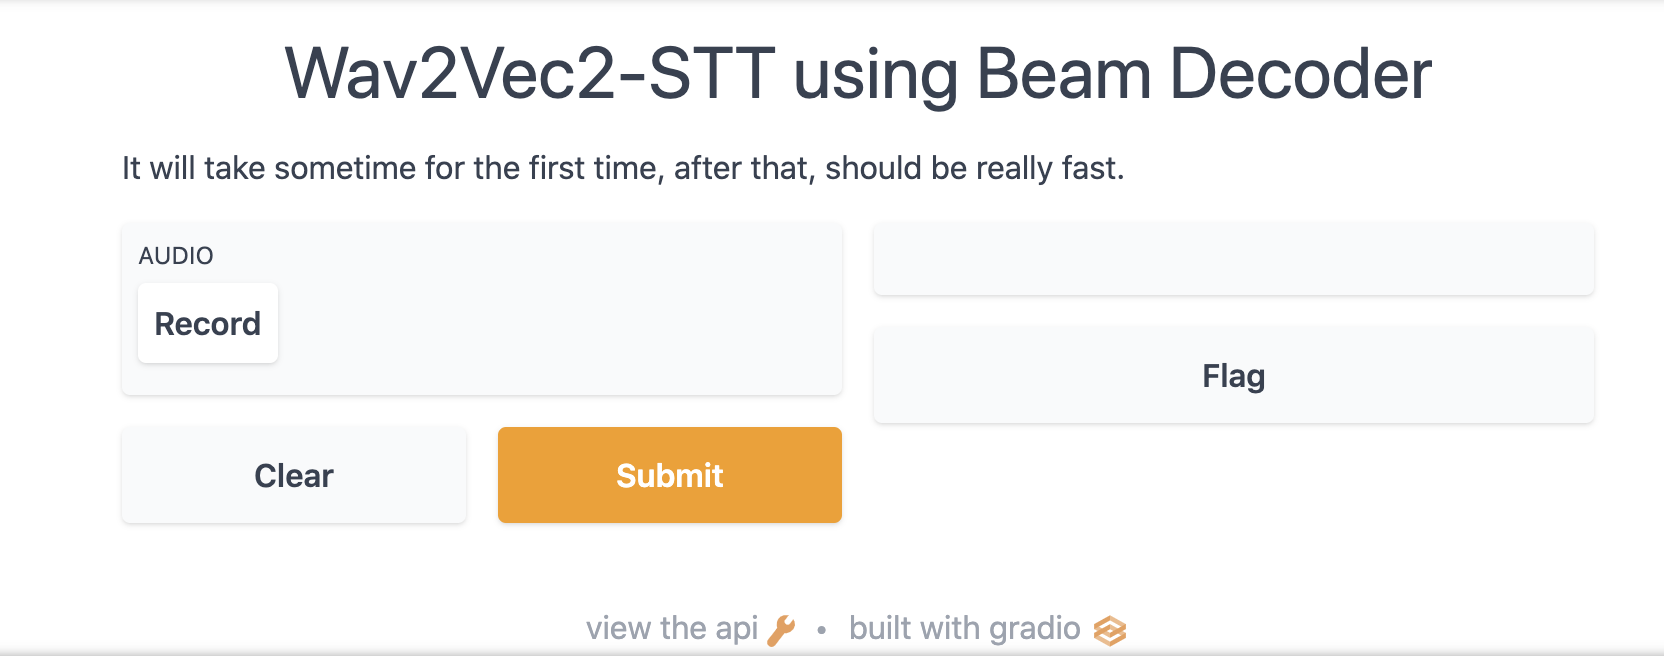

In [9]:
from IPython.core.display import Image, display

display(Image('record-mode.png', width=800))

#### upload mode

In [8]:
model.gradio(record_mode = False)

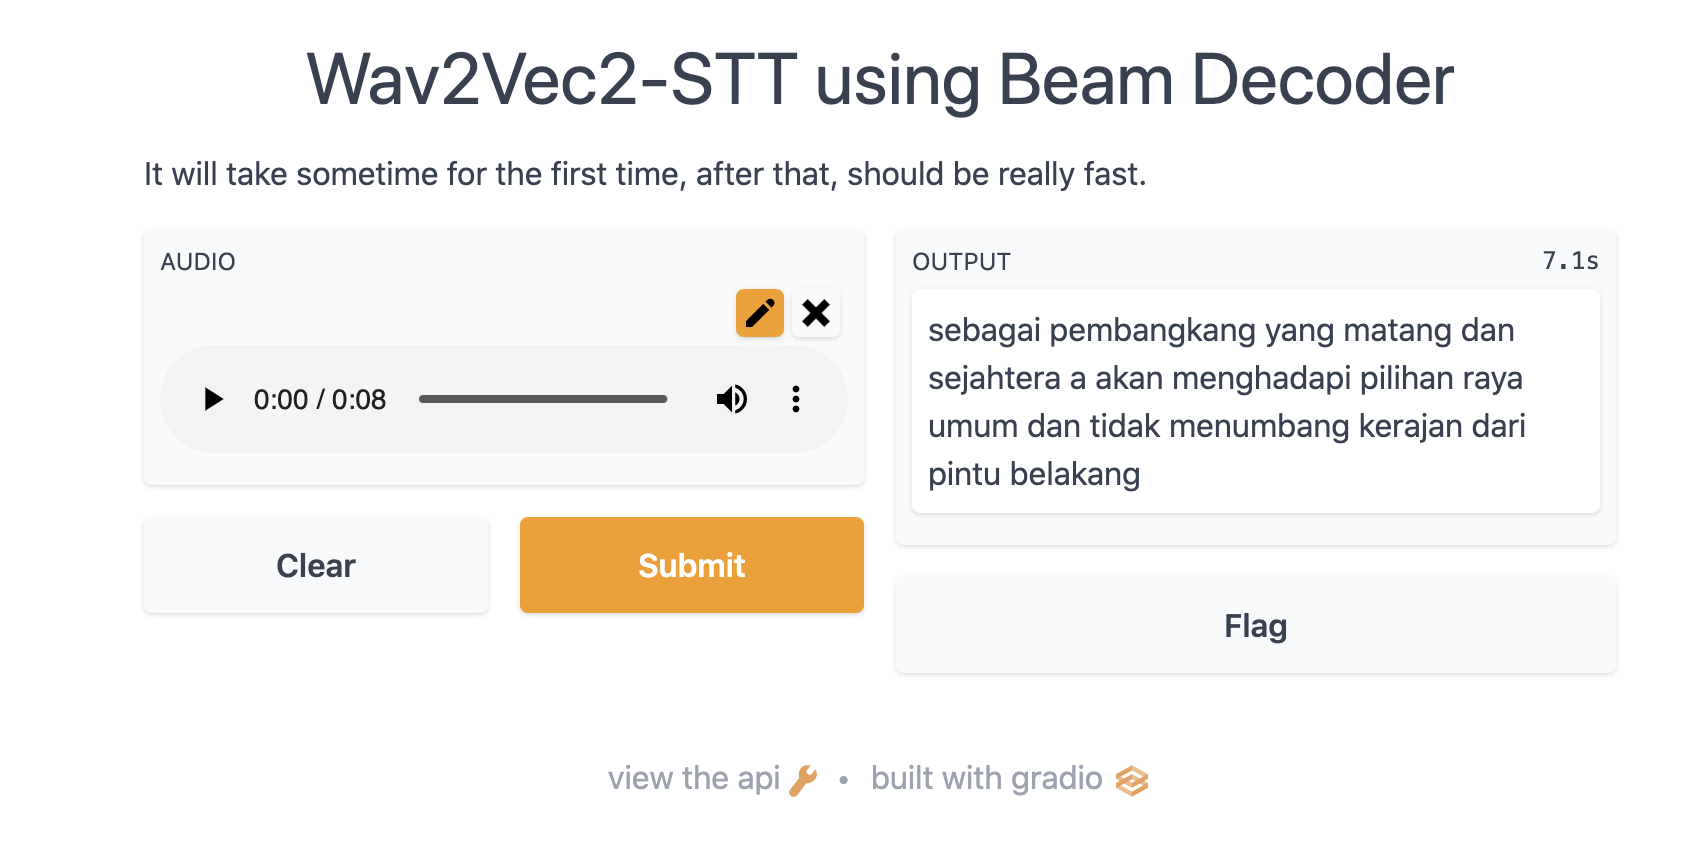

In [10]:
from IPython.core.display import Image, display

display(Image('upload-mode.png', width=800))

#### Use Language model

In [4]:
from functools import partial
from pyctcdecode import build_ctcdecoder
from malaya_speech.utils.char import CTC_VOCAB
import kenlm

In [5]:
lm = malaya_speech.stt.language_model(model = 'dump-combined')

In [6]:
kenlm_model = kenlm.Model(lm)
decoder = build_ctcdecoder(
    CTC_VOCAB + ['_'],
    kenlm_model,
    alpha=0.2,
    beta=1.0,
    ctc_token_idx=len(CTC_VOCAB)
)

In [7]:
def return_lm(logits):
    out = decoder.decode_beams(logits, prune_history=True)
    d_lm, lm_state, timesteps, logit_score, lm_score = out[0]
    return d_lm

In [9]:
model.gradio(record_mode = False, lm_func = return_lm)

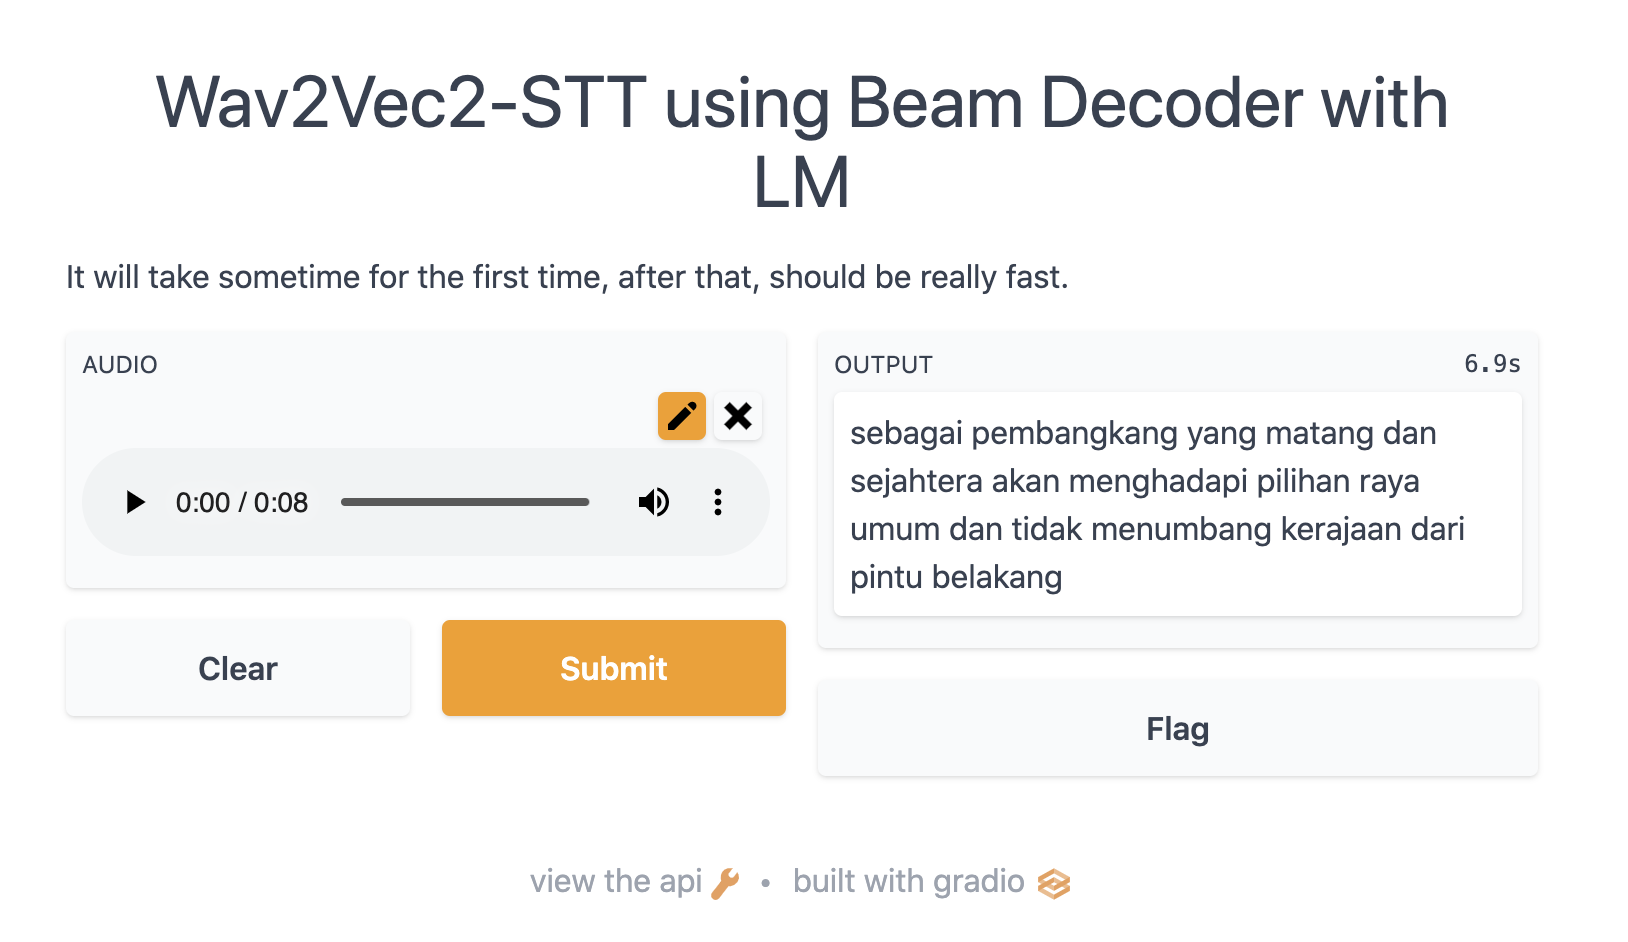

In [10]:
from IPython.core.display import Image, display

display(Image('upload-mode-lm.png', width=800))